In [1]:
from langgraph.graph import START, StateGraph, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field


load_dotenv()

True

In [2]:
model = ChatOpenAI(model='gpt-4o-mini')

In [3]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    issuetype: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The category of the issue mentioned in the review")
    tone: Literal["angry", "frustated", "disappointed", "calm"]=Field(description="The emotional tone expressed by the user")
    urgency: Literal["low", "medium", "high"]=Field(description="How urgent or critical the issue appears to be")

In [4]:
sentimentModel = model.with_structured_output(SentimentSchema)
diagnosisModel = model.with_structured_output(DiagnosisSchema)

In [5]:
prompt = f"What is the sentiment of the following review: The software is good. Certain features remain challenging with no support"
sentimentModel.invoke(prompt).sentiment
diagnosisModel.invoke(prompt)


DiagnosisSchema(issuetype='Support', tone='disappointed', urgency='medium')

In [6]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive", "negative"]
    diagnosis: dict
    response:str

In [7]:
def findsentiment(state:ReviewState):
    prompt = f'For the following review, find the sentiment \n {state['review']}'
    sentiment = sentimentModel.invoke(prompt).sentiment

    return {'sentiment':sentiment}

def positiveresponse(state:ReviewState):
    prompt = f"""Write a warm thank-You message in response to the this review:
    \n\n "{state['review']}\"\n
    Also, Kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content
    return {'response':response}

def check_sentiment(state:ReviewState) -> Literal["positiveresponse","rundiagnosis"]:
    if state['sentiment'] =='positive':
        return 'positiveresponse'
    else:
        return 'rundiagnosis'
    
def rundiagnosis(state:ReviewState):
    prompt = f"""Diagnose this negative review: \n\n{state['review']}\n
            Return issue_type, tone and urgency.""" 
    response = diagnosisModel.invoke(prompt)
    return {'diagnosis':response.model_dump()}

def negativeresponse(state:ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issuetype']}' issue, sounded '{diagnosis['tone']}' and marked urgency as  '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message"""

    response = model.invoke(prompt).content
    return {'response':response}

In [8]:
graph = StateGraph(ReviewState)

graph.add_node('findsentiment', findsentiment)
graph.add_node('positiveresponse', positiveresponse)
graph.add_node('rundiagnosis', rundiagnosis)
graph.add_node('negativeresponse', negativeresponse)

#edges
graph.add_edge(START, 'findsentiment')
graph.add_conditional_edges('findsentiment', check_sentiment)
graph.add_edge('positiveresponse', END)
graph.add_edge('rundiagnosis', 'negativeresponse')
graph.add_edge('negativeresponse', END)

workflow = graph.compile()

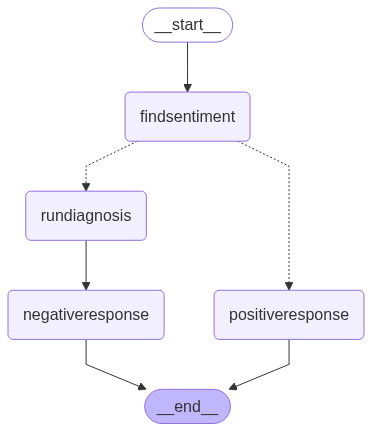

In [9]:
workflow

In [10]:
initial_state = {
    'review':"I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(initial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issuetype': 'Bug', 'tone': 'frustated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI hope this message finds you well. I understand how frustrating it can be to deal with a bug, especially when it feels urgent. I want to assure you that we're here to help and address your concerns as quickly as possible.\n\nCould you please provide me with a bit more detail about the issue you’re experiencing? Specifically, any steps to reproduce the bug, any error messages you're seeing, and the device or platform you’re using would be incredibly helpful. With this information, we can work together to find a resolution.\n\nThank you for your patience, and I’